In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO3_preprocessed.csv', parse_dates=['datetime'])

data=data[['datetime', 'price']]
data.set_index('datetime', drop=True, inplace=True)
data


price
datetime                     
2020-01-01 00:00:00   28387.0
2020-01-01 01:00:00   28062.0
2020-01-01 02:00:00   27519.0
2020-01-01 03:00:00   27144.0
2020-01-01 04:00:00   27164.0
...                       ...
2023-03-29 20:00:00  144605.0
2023-03-29 21:00:00  115553.0
2023-03-29 22:00:00   99660.0
2023-03-29 23:00:00   73353.0
2023-03-30 00:00:00  101233.0

[28417 rows x 1 columns]

In [2]:
def prepare_data_lstm(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler()
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    # reshape input data into 3D tensor (batch_size, seq_len, input_size)
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [3]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set = prepare_data_lstm(data)

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout, batch_size, seq_length):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim + exog_dim, output_dim)

    def forward(self, x, exog):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = torch.cat((out[:, -1, :], exog.view(exog.size(0), -1)), dim=1)
        out = self.fc(out)
        return out

# set hyperparameters
input_dim = train_X.shape[2]
output_dim = 1
hidden_dim = 15
num_layers = 4
batch_size = 97
exog_dim = train_X.shape[2]
seq_length=22

#Trial 20 finished with value: 0.02964043617248535 and parameters: {'hidden_dim': 15, 'num_layers': 4, 'dropout': 0.21109869589375793, 'lr': 0.0005113226180926156, 'batch_size': 97, 'seq_length': 22}. Best is trial 20 with value: 0.02964043617248535.


# initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropout = 0.21109869589375793
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout, batch_size, seq_length).to(device)

# set loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005113226180926156)

# train model
num_epochs = 30
for epoch in range(num_epochs):
    for i in range(0, train_X.shape[0] - batch_size, batch_size):
        # get batch of data
        x = torch.tensor(train_X[i:i+batch_size]).float().to(device)
        y = torch.tensor(train_y[i:i+batch_size]).float().to(device)
        exog = torch.tensor(train_X[i:i+batch_size, -exog_dim:]).float().to(device)

        # forward pass
        outputs = model(x, exog)
        loss = criterion(outputs, y)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/30], Loss: 0.0021
Epoch [10/30], Loss: 0.0017
Epoch [20/30], Loss: 0.0022


RMSE: 30100.5560, MAPE: 48.5833% , MAE:  22870.5953, RSS:  1914469851193.1506


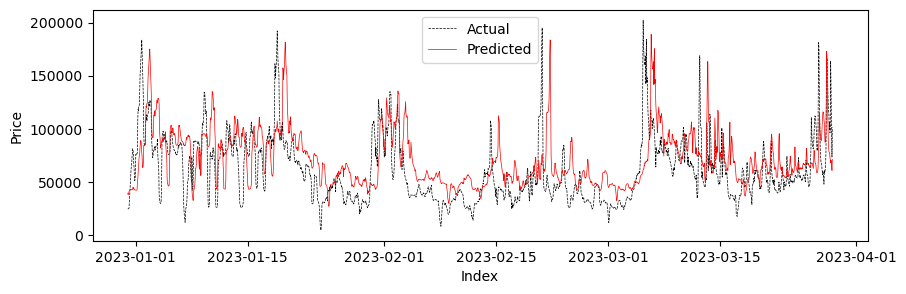

In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# evaluate model
model.eval()
preds = []
for i in range(0, test_X.shape[0]):
    x = torch.tensor(test_X[i]).float().to(device).unsqueeze(0)
    exog = torch.tensor(test_X[i, -exog_dim:]).float().to(device)
    y_pred = model(x, exog).cpu().detach().numpy().squeeze()
    preds.append(y_pred)

# invert scaling to get unscaled predictions
preds = np.array(preds).reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)
# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, linestyle='--', c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
from numpy import inf

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
mape = []
rmse=[]
mae=[]
forecast = pd.Series()

# set hyperparameters
hidden_dim = 41
num_layers = 3
dropout = 0.06066797078286349
lr = 8.707743672846187e-05
batch_size=64
seq_length=24

# initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout, batch_size, seq_length).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 2
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
    print(f"Fold {fold+1}/{tscv.get_n_splits()}")

    for epoch in range(num_epochs):
        for i in range(0, train_index.shape[0] - batch_size, batch_size):
            # get batch of data
            x = torch.tensor(train_X[train_index][i:i+batch_size]).float().to(device)
            y = torch.tensor(train_y[train_index][i:i+batch_size]).float().to(device)
            exog = torch.tensor(train_X[train_index][i:i+batch_size, -exog_dim:]).float().to(device)

            # forward pass
            outputs = model(x, exog)
            loss = criterion(outputs, y)

            # backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
    
    preds = []
    for i in range(val_index.shape[0]):
        x = torch.tensor(train_X[val_index][i]).float().to(device).unsqueeze(0)
        exog = torch.tensor(train_X[val_index][i, -exog_dim:]).float().to(device)
        y_pred = model(x, exog).cpu().detach().numpy().squeeze()
        preds.append(y_pred)
    
    # invert scaling to get unscaled predictions
    preds = np.array(preds).reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])

    y_val = np.array(train_y[val_index]).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    # Calculate RMSE and MAPE for this prediction
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mape.append(mean_absolute_percentage_error(y_val, preds))
    mae.append(mean_absolute_error(y_val, preds))

# Calculate and print mean RMSE and MAPE over all predictions
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Fold 1/365
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0021


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_38623/3197002308.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast = pd.Series()


Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0015
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0031
Epoch [1/2], Loss: 0.0088
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0032
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0040
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0098
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0028
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0021
Epoch [1/2],

Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0006
Epoch [0/2],

Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0012
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0031
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0020
Epoch [1/2],

Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2],

Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0093
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2],

Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2],

Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0040
Epoch [1/2],

Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0006
Epoch [1/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0087
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0006
Epoch [0/2],

Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2],

Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0082
Epoch [1/2], Loss: 0.0026
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0026
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0009
Epoch [1/2],

Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0075
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0010
Epoch [0/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0223
Epoch [0/2], Loss: 0.0532
Epoch [0/2], Loss: 0.0256
Epoch [0/2], Loss: 0.0095
Epoch [0/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0009
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0181
Epoch [0/2], Loss: 0.0366
Epoch [0/2], Loss: 0.0182
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0004
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0139
Epoch [1/2], Loss: 0.0199
Epoch [1/2], Loss: 0.0124
Epoch [1/2], Loss: 0.0068
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0136
Epoch [0/2], Loss: 0.0196
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0043
Fold 37/365
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000


Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0041
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0192
Epoch [1/2], Loss: 0.0123
Epoch [1/2], Loss: 0.0065
Epoch [1/2], Loss: 0.0047
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Fold 50/365
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000


Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0132
Epoch [0/2], Loss: 0.0197
Epoch [0/2], Loss: 0.0120
Epoch [0/2], Loss: 0.0064
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0014
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0189
Epoch [0/2], Loss: 0.0122
Epoch [0/2], Loss: 0.0066
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0043
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2],

Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0092
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0012
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0134
Epoch [1/2], Loss: 0.0195
Epoch [1/2], Loss: 0.0121
Epoch [1/2], Loss: 0.0062
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0133
Epoch [0/2], Loss: 0.0195
Epoch [0/2], Loss: 0.0120
Epoch [0/2], Loss: 0.0063
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0090
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Fold 69/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000


Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0195
Epoch [0/2], Loss: 0.0121
Epoch [0/2], Loss: 0.0064
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0005
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0199
Epoch [1/2], Loss: 0.0121
Epoch [1/2], Loss: 0.0062
Epoch [1/2], Loss: 0.0046
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0091
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0090
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Fold 81/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000


Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2],

Fold 83/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000


Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0133
Epoch [0/2], Loss: 0.0196
Epoch [0/2], Loss: 0.0121
Epoch [0/2], Loss: 0.0063
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0014
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0135
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0089
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Fold 90/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000


Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0013
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0053
Fold 94/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000


Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0015
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0199
Epoch [0/2], Loss: 0.0121
Epoch [0/2], Loss: 0.0059
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0133
Epoch [0/2], Loss: 0.0200
Epoch [0/2], Loss: 0.0121
Epoch [0/2], Loss: 0.0060
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0134
Epoch [0/2], Loss: 0.0199
Epoch [0/2], Loss: 0.0121
Epoch [0/2], Loss: 0.0062
Epoch [0/2], Loss: 0.0047
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0090
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0198
Epoch [0/2], Loss: 0.0120
Epoch [0/2], Loss: 0.0060
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0203
Epoch [0/2], Loss: 0.0121
Epoch [0/2], Loss: 0.0057
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0200
Epoch [0/2], Loss: 0.0120
Epoch [0/2], Loss: 0.0058
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0133
Epoch [0/2], Loss: 0.0203
Epoch [0/2], Loss: 0.0120
Epoch [0/2], Loss: 0.0058
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0205
Epoch [0/2], Loss: 0.0122
Epoch [0/2], Loss: 0.0058
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0089
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0069
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Fold 118/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0088
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0070
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Fold 120/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0135
Epoch [1/2], Loss: 0.0201
Epoch [1/2], Loss: 0.0120
Epoch [1/2], Loss: 0.0058
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0089
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0135
Epoch [1/2], Loss: 0.0209
Epoch [1/2], Loss: 0.0122
Epoch [1/2], Loss: 0.0057
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0137
Epoch [1/2], Loss: 0.0208
Epoch [1/2], Loss: 0.0123
Epoch [1/2], Loss: 0.0058
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0137
Epoch [1/2], Loss: 0.0210
Epoch [1/2], Loss: 0.0122
Epoch [1/2], Loss: 0.0058
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0053
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0068
Epoch [0/2], Loss: 0.0054
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0069
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0089
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0068
Epoch [0/2], Loss: 0.0053
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0068
Epoch [0/2], Loss: 0.0008
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0136
Epoch [0/2], Loss: 0.0213
Epoch [0/2], Loss: 0.0123
Epoch [0/2], Loss: 0.0057
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0209
Epoch [0/2], Loss: 0.0124
Epoch [0/2], Loss: 0.0057
Epoch [0/2],

Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Fold 139/365
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0088
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0068
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0135
Epoch [1/2], Loss: 0.0208
Epoch [1/2], Loss: 0.0124
Epoch [1/2], Loss: 0.0057
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0088
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0053
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0137
Epoch [0/2], Loss: 0.0209
Epoch [0/2], Loss: 0.0122
Epoch [0/2], Loss: 0.0055
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Fold 148/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0088
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0135
Epoch [1/2], Loss: 0.0209
Epoch [1/2], Loss: 0.0122
Epoch [1/2], Loss: 0.0056
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0087
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0033
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0110
Fold 157/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0138
Epoch [1/2], Loss: 0.0215
Epoch [1/2], Loss: 0.0123
Epoch [1/2], Loss: 0.0055
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0108
Epoch [0/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0086
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0086
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0108
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0068
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0068
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0109
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0087
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0032
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0136
Epoch [0/2], Loss: 0.0218
Epoch [0/2], Loss: 0.0123
Epoch [0/2], Loss: 0.0053
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0109
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Fold 172/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0223
Epoch [1/2], Loss: 0.0125
Epoch [1/2], Loss: 0.0054
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0109
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0032
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0107
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Fold 177/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0108
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0032
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0109
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0087
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0055
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0085
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0138
Epoch [0/2], Loss: 0.0220
Epoch [0/2], Loss: 0.0124
Epoch [0/2], Loss: 0.0053
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0107
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Fold 190/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0066
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0109
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0137
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0043
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0084
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0222
Epoch [1/2], Loss: 0.0122
Epoch [1/2], Loss: 0.0054
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2],

Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0108
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0086
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0032
Epoch [1/2], Loss: 0.0021
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0224
Epoch [1/2], Loss: 0.0125
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0035
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0107
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0219
Epoch [1/2], Loss: 0.0124
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0107
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0223
Epoch [1/2], Loss: 0.0124
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0046
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0108
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0224
Epoch [1/2], Loss: 0.0124
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0066
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0108
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0135
Epoch [1/2], Loss: 0.0219
Epoch [1/2], Loss: 0.0124
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0107
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0085
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0066
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0038
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0136
Epoch [0/2], Loss: 0.0221
Epoch [0/2], Loss: 0.0126
Epoch [0/2], Loss: 0.0053
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0086
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0108
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Fold 223/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0015
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0137
Epoch [0/2], Loss: 0.0221
Epoch [0/2], Loss: 0.0122
Epoch [0/2], Loss: 0.0053
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0065
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0108
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0086
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0085
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0107
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0159
Fold 230/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0085
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0050
Epoch [1/2], Loss: 0.0031
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0050
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0158
Epoch [0/2], Loss: 0.0078
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0016
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0138
Epoch [1/2],

Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0086
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0067
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0106
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0157
Epoch [1/2], Loss: 0.0078
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0042
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0084
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0105
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0156
Epoch [1/2], Loss: 0.0077
Epoch [1/2], Loss: 0.0031
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0004
Fold 241/365
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0039
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0139
Epoch [1/2], Loss: 0.0237
Epoch [1/2], Loss: 0.0125
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0046
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0084
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0106
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0138
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0085
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0031
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0049
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0066
Epoch [1/2], Loss: 0.0008
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0157
Epoch [0/2], Loss: 0.0076
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0140
Epoch [0/2], Loss: 0.0238
Epoch [0/2], Loss: 0.0127
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0065
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0103
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0155
Epoch [0/2], Loss: 0.0076
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0700
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0139
Epoch [0/2], Loss: 0.0243
Epoch [0/2], Loss: 0.0126
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0043
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0082
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0104
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0154
Epoch [1/2], Loss: 0.0077
Epoch [1/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0130
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2],

Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0134
Epoch [0/2], Loss: 0.0246
Epoch [0/2], Loss: 0.0125
Epoch [0/2], Loss: 0.0049
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0009
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0084
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0049
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0066
Epoch [1/2], Loss: 0.0047
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0062
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2],

Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0150
Epoch [0/2], Loss: 0.0076
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0677
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0130
Epoch [0/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0137
Epoch [1/2], Loss: 0.0251
Epoch [1/2], Loss: 0.0129
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0046
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0033
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0049
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0066
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0061
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0102
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0150
Epoch [1/2], Loss: 0.0074
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0671
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0129
Epoch [1/2], Loss: 0.0270
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0004
Fold 266/365
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0138
Epoch [0/2], Loss: 0.0257
Epoch [0/2], Loss: 0.0127
Epoch [0/2], Loss: 0.0047
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0009
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0082
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0049
Epoch [1/2], Loss: 0.0028
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0065
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0061
Epoch [1/2], Loss: 0.0010
Epoch [1/2],

Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0099
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0268
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0003
Fold 271/365
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0139
Epoch [1/2], Loss: 0.0262
Epoch [1/2], Loss: 0.0132
Epoch [1/2],

Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0043
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0082
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0049
Epoch [0/2],

Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0100
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0658
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0132
Epoch [0/2], Loss: 0.0266
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0075
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0061
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0100
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0148
Epoch [1/2], Loss: 0.0073
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0655
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0134
Epoch [1/2], Loss: 0.0264
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0074
Epoch [1/2], Loss: 0.0053
Fold 280/365
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0141
Epoch [0/2], Loss: 0.0274
Epoch [0/2], Loss: 0.0131
Epoch [0/2], Loss: 0.0047
Epoch [0/2], Loss: 0.0047
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0065
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0061
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0099
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0147
Epoch [0/2], Loss: 0.0073
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0649
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0131
Epoch [1/2], Loss: 0.0264
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0075
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0013
Fold 285/365
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0140
Epoch [0/2], Loss: 0.0277
Epoch [0/2], Loss: 0.0133
Epoch [0/2], Loss: 0.0047
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0065
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0060
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0099
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0147
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0647
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0134
Epoch [1/2], Loss: 0.0263
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0074
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Fold 292/365
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0139
Epoch [1/2], Loss: 0.0280
Epoch [1/2], Loss: 0.0132
Epoch [1/2], Loss: 0.0047
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0082
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0059
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0079
Epoch [0/2], Loss: 0.0099
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0147
Epoch [1/2], Loss: 0.0073
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0646
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0132
Epoch [1/2], Loss: 0.0261
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0074
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0141
Epoch [0/2], Loss: 0.0277
Epoch [0/2], Loss: 0.0134
Epoch [0/2], Loss: 0.0047
Epoch [0/2],

Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0059
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0098
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0147
Epoch [1/2], Loss: 0.0073
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0644
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0131
Epoch [1/2], Loss: 0.0258
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0020
Epoch [1/2],

Epoch [0/2], Loss: 0.0134
Epoch [0/2], Loss: 0.0260
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0074
Epoch [0/2], Loss: 0.0052
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0141
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0140
Epoch [1/2], Loss: 0.0287
Epoch [1/2], Loss: 0.0134
Epoch [1/2], Loss: 0.0047
Epoch [1/2], Loss: 0.0047
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0141
Epoch [0/2], Loss: 0.0286
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0007
Epoch [0/2],

Epoch [1/2], Loss: 0.0046
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0081
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0060
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0097
Epoch [1/2], Loss: 0.0028
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0147
Epoch [0/2], Loss: 0.0073
Epoch [0/2], Loss: 0.0029
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0640
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0133
Epoch [0/2], Loss: 0.0258
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0015
Epoch [0/2],

Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0075
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Fold 311/365
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0037
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0142
Epoch [1/2], Loss: 0.0287
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0142
Epoch [0/2], Loss: 0.0286
Epoch [0/2], Loss: 0.0135
Epoch [0/2], Loss: 0.0047
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0065
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0059
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2],

Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0044
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0060
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0098
Epoch [0/2], Loss: 0.0028
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0146
Epoch [1/2], Loss: 0.0071
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0639
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0133
Epoch [1/2], Loss: 0.0256
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0075
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0023
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0146
Epoch [0/2], Loss: 0.0072
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0638
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0132
Epoch [0/2], Loss: 0.0257
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0075
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0043
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0012
Fold 320/365
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0012
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0140
Epoch [0/2], Loss: 0.0286
Epoch [0/2], Loss: 0.0134
Epoch [0/2], Loss: 0.0047
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0081
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0066
Epoch [0/2], Loss: 0.0045
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0060
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0060
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0098
Epoch [1/2], Loss: 0.0028
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0147
Epoch [0/2], Loss: 0.0072
Epoch [0/2], Loss: 0.0030
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0636
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0132
Epoch [0/2], Loss: 0.0257
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0015
Epoch [0/2],

Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0638
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0133
Epoch [1/2], Loss: 0.0256
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0074
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0027
Fold 328/365
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001

Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0043
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0269
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0037
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0036
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0141
Epoch [1/2], Loss: 0.0298
Epoch [1/2], Loss: 0.0136
Epoch [1/2], Loss: 0.0046
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0014
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0079
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0048
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0043
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0059
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0146
Epoch [1/2], Loss: 0.0071
Epoch [1/2], Loss: 0.0030
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0630
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0134
Epoch [1/2], Loss: 0.0252
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0074
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.1378
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0038
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0085
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0048
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0024
Epoch [1/2],

Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0105
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0150
Epoch [0/2], Loss: 0.0075
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0049
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0287
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.1278
Epoch [1/2], Loss: 0.0592
Fold 341/365
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0120
Epoch [1/2], Loss: 0.0206
Epoch [1/2], Loss: 0.0112
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0041
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0023
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0054
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0064
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0114
Epoch [0/2], Loss: 0.0035
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0158
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0031
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0676
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0109
Epoch [1/2], Loss: 0.0277
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0075
Epoch [1/2], Loss: 0.0066
Epoch [1/2], Loss: 0.0031
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0051
Epoch [1/2], Loss: 0.0023
Epoch [1/2],

Epoch [0/2], Loss: 0.0081
Epoch [0/2], Loss: 0.0031
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0682
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0107
Epoch [0/2], Loss: 0.0283
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0075
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0032
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0021
Epoch [0/2], Loss: 0.0051
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0315
Epoch [0/2], Loss: 0.0004
Epoch [0/2],

Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0688
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0108
Epoch [1/2], Loss: 0.0290
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0075
Epoch [1/2], Loss: 0.0069
Epoch [1/2], Loss: 0.0032
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0052
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0316
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.1174
Epoch [1/2], Loss: 0.0385
Epoch [1/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0027
Epoch [1/2], Loss: 0.0337
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.1124
Epoch [1/2], Loss: 0.0288
Epoch [1/2], Loss: 0.0125
Epoch [1/2], Loss: 0.0278
Epoch [1/2], Loss: 0.0173
Fold 349/365
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002

Epoch [0/2], Loss: 0.0069
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0081
Epoch [0/2], Loss: 0.0125
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0111
Epoch [1/2], Loss: 0.0169
Epoch [1/2], Loss: 0.0112
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2],

Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0171
Epoch [0/2], Loss: 0.0093
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0027
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0753
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0098
Epoch [0/2], Loss: 0.0335
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0077
Epoch [0/2], Loss: 0.0077
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0022
Epoch [0/2], Loss: 0.0059
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0020
Epoch [0/2], Loss: 0.0011
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0046
Epoch [1/2], Loss: 0.0047
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0103
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0053
Epoch [1/2], Loss: 0.0042
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0066
Epoch [1/2], Loss: 0.0066
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0072
Epoch [1/2], Loss: 0.0014
Epoch [1/2], Loss: 0.0007
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0017
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0033
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0059
Epoch [1/2], Loss: 0.0025
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0028
Epoch [1/2], Loss: 0.0370
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.1041
Epoch [1/2], Loss: 0.0164
Epoch [1/2], Loss: 0.0087
Epoch [1/2], Loss: 0.0241
Epoch [1/2], Loss: 0.0108
Epoch [1/2], Loss: 0.0508
Epoch [1/2], Loss: 0.0528
Fold 354/365
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0176
Epoch [0/2], Loss: 0.0099
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0026
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0795
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0100
Epoch [0/2], Loss: 0.0362
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0079
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0054
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0021
Epoch [1/2], Loss: 0.0066
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0075
Epoch [1/2], Loss: 0.0013
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0133
Epoch [1/2], Loss: 0.0041
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0109
Epoch [0/2], Loss: 0.0164
Epoch [0/2], Loss: 0.0115
Epoch [0/2], Loss: 0.0076
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0046
Epoch [0/2], Loss: 0.0047
Epoch [0/2],

Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0009
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0022
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0018
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0028
Epoch [1/2], Loss: 0.0377
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.1030
Epoch [1/2], Loss: 0.0121
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0243
Epoch [1/2], Loss: 0.0100
Epoch [1/2], Loss: 0.0467
Epoch [1/2], Loss: 0.0506
Epoch [1/2], Loss: 0.0026
Epoch [1/2], Loss: 0.0054
Fold 358/365
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0177
Epoch [0/2], Loss: 0.0102
Epoch [0/2], Loss: 0.0033
Epoch [0/2], Loss: 0.0025
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0837
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0104
Epoch [0/2], Loss: 0.0380
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0017
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0102
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0055
Epoch [1/2], Loss: 0.0045
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0068
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0076
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0081
Epoch [1/2],

Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0111
Epoch [0/2], Loss: 0.0170
Epoch [0/2], Loss: 0.0118
Epoch [0/2], Loss: 0.0082
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0014
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0016
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0002
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0020
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0082
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0035
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0057
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0017
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0029
Epoch [1/2], Loss: 0.0380
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.1030
Epoch [1/2], Loss: 0.0110
Epoch [1/2], Loss: 0.0081
Epoch [1/2], Loss: 0.0245
Epoch [1/2], Loss: 0.0097
Epoch [1/2], Loss: 0.0455
Epoch [1/2], Loss: 0.0490
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0056
Epoch [1/2], Loss: 0.0066
Fold 362/365
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0003

Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0081
Epoch [0/2], Loss: 0.0133
Epoch [0/2], Loss: 0.0039
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0178
Epoch [0/2], Loss: 0.0098
Epoch [0/2], Loss: 0.0034
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0001
Epoch [0/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0044
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0102
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0054
Epoch [1/2], Loss: 0.0043
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0019
Epoch [1/2], Loss: 0.0066
Epoch [1/2], Loss: 0.0067
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0077
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0112
Epoch [0/2], Loss: 0.0174
Epoch [0/2], Loss: 0.0118
Epoch [0/2], Loss: 0.0080
Epoch [0/2], Loss: 0.0050
Epoch [0/2], Loss: 0.0013
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0015
Epoch [0/2], Loss: 0.0010
Epoch [0/2], Loss: 0.0003
Epoch [0/2],

Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0009
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0008
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0004
Epoch [1/2],

Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0007
Epoch [0/2], Loss: 0.0012
Epoch [0/2], Loss: 0.0019
Epoch [0/2], Loss: 0.0011
Epoch [0/2], Loss: 0.0017
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0004
Epoch [0/2], Loss: 0.0006
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0036
Epoch [0/2], Loss: 0.0018
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0005
Epoch [0/2], Loss: 0.0003
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0002
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2],

Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0008
Epoch [0/2], Loss: 0.0001
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2], Loss: 0.0000
Epoch [0/2],

Epoch [0/2], Loss: 0.0103
Epoch [0/2], Loss: 0.0076
Epoch [0/2], Loss: 0.0246
Epoch [0/2], Loss: 0.0094
Epoch [0/2], Loss: 0.0442
Epoch [0/2], Loss: 0.0496
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0056
Epoch [0/2], Loss: 0.0065
Epoch [0/2], Loss: 0.0024
Epoch [0/2], Loss: 0.0040
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0003
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2],

Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0000
Epoch [1/2], Loss: 0.0006
Epoch [1/2], Loss: 0.0179
Epoch [1/2], Loss: 0.0099
Epoch [1/2], Loss: 0.0034
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0005
Epoch [1/2], Loss: 0.0856
Epoch [1/2], Loss: 0.0010
Epoch [1/2], Loss: 0.0110
Epoch [1/2], Loss: 0.0385
Epoch [1/2], Loss: 0.0007
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0004
Epoch [1/2], Loss: 0.0015
Epoch [1/2], Loss: 0.0084
Epoch [1/2], Loss: 0.0080
Epoch [1/2], Loss: 0.0032
Epoch [1/2], Loss: 0.0012
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0002
Epoch [1/2], Loss: 0.0001
Epoch [1/2], Loss: 0.0023
Epoch [1/2], Loss: 0.0057
Epoch [1/2], Loss: 0.0024
Epoch [1/2], Loss: 0.0016
Epoch [1/2], Loss: 0.0011
Epoch [1/2], Loss: 0.0008
Epoch [1/2],

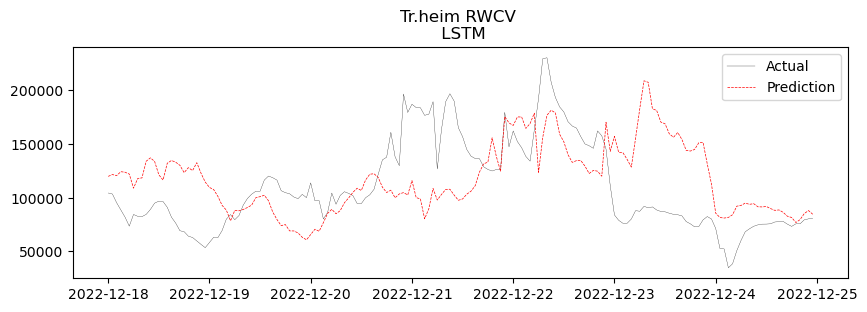

In [12]:
# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*13:-24*6].values, train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*13:-24*6].values, forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tr.heim RWCV \n LSTM')
plt.legend()
plt.show()

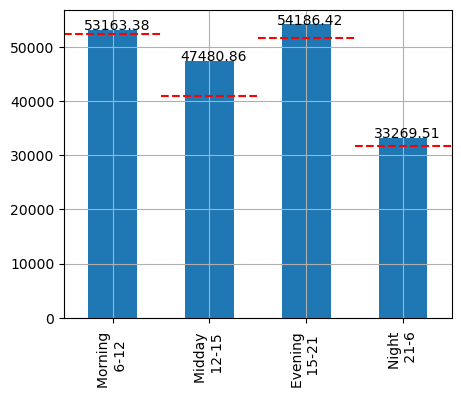

In [13]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31766, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    
    
plt.show()

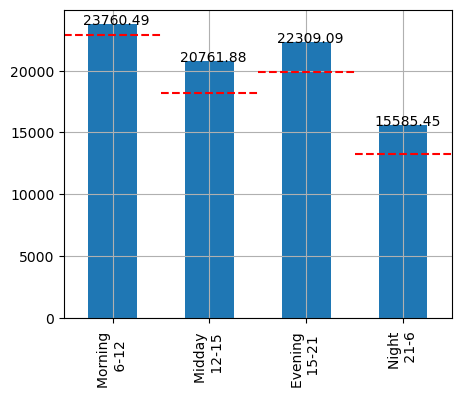

In [14]:

mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))

plt.show()

In [15]:
# compute the residuals
residuals = train_set['target'][:365*24].values - forecast

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

Residual Sum of Squares (RSS):  21033926289583.734


RMSE: 42229664647.8049, MAPE: 99.9998% , MAE:  37695985549.9441, RSS:  3768207089650193525637120.0000


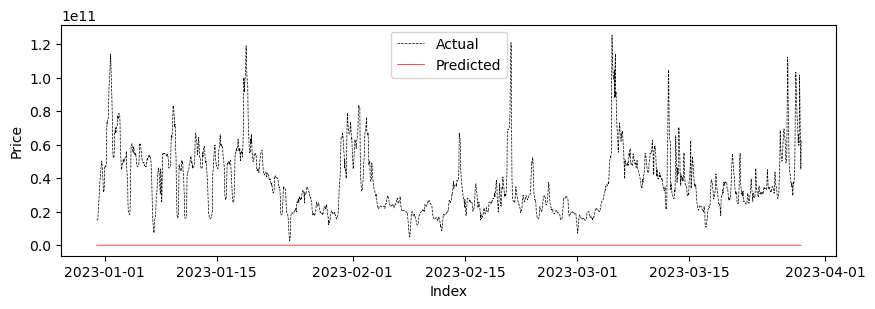

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# evaluate model
model.eval()
preds = []
for i in range(0, test_X.shape[0]):
    x = torch.tensor(test_X[i]).float().to(device).unsqueeze(0)
    exog = torch.tensor(test_X[i, -exog_dim:]).float().to(device)
    y_pred = model(x, exog).cpu().detach().numpy().squeeze()
    preds.append(y_pred)

# invert scaling to get unscaled predictions
preds = np.array(preds).reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)
# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, linestyle='--', c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()
